### Imports & data Directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from natsort import natsorted, ns
from skimage import io, color


%matplotlib inline

In [2]:
#Directory
data = 'HPTLCRaw\\'

### Grey Scale Import

##### Import Images as Grey Scale

In [3]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

##### Crop all Images

In [4]:
cropped_img_list = []
for image in image_list:
    cropped_img_list.append(image[70:1100,96:-84])

##### Plot Every Cropped File as a Greyscale Image

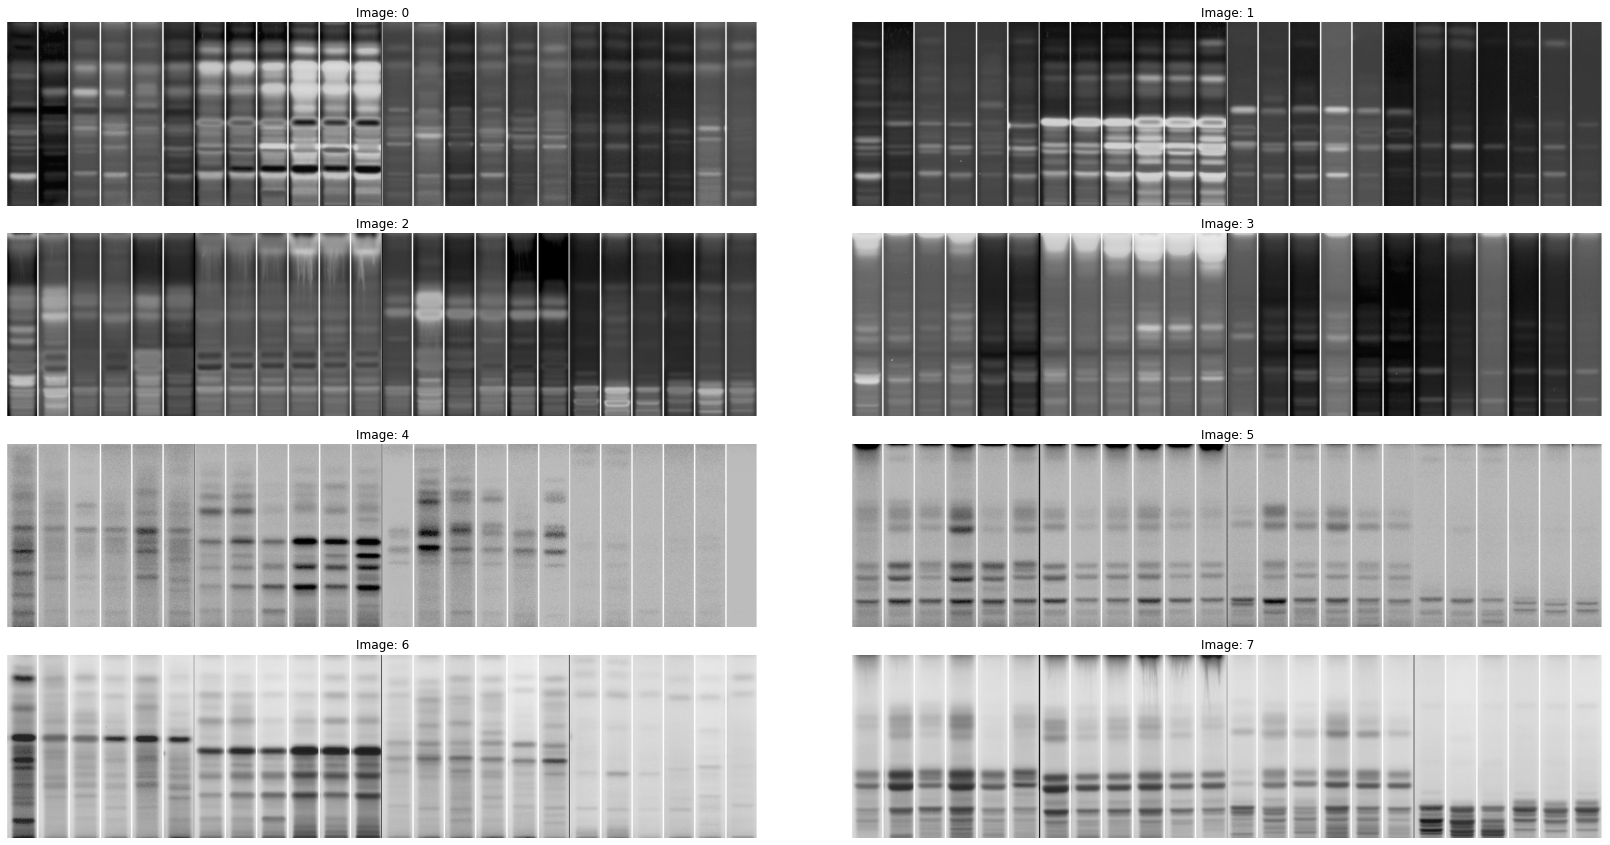

In [5]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

##### Verifying Shape of each Cropped Image


In [6]:
for i in range(len(cropped_img_list)):
    print(np.shape(cropped_img_list[i]))

(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)


### Algorithm to determine crop locations

In [7]:
def det_crop_locations(ar):
    maxVal = ar.max()
    res = []
    res.append([0,0])
    n = len(ar)

    i = 10
    while i < len(ar-5):
        # While we are within bounds and
        # we have not found a peak or
        # haven't yet travelled at least 100 pixels or
        # are not within 5% of the max value
        # increment i
        while (i < n-5) and (not (ar[i] >= ar[i-1] and ar[i] >= ar[i+1]) or not (i - res[-1][0] > 100) or not(ar[i] > (.85*maxVal))):
            i += 1

        #if we reach the end of the image, break the loop
        if i >= n-5:
            break

        # Add Back wall of single strip to q
        res[-1][1] = i - 15
        
        #Add front wall to q
        res.append([i + 15,0])
        
    #remove last appended crop as it is at the end of the image and therefore not useful
    res.pop()
    return res

#### Use Function to Determine Crop Locations of Each Image

In [8]:
crops_list = []
for cropped_img in cropped_img_list:
    temp = pd.DataFrame(cropped_img)
    temp_hi_cnt = temp[temp>.8].count()
    temp_low_cnt = temp[temp==0].count()
    temp_cnt = temp_hi_cnt + temp_low_cnt
    crops_list.append(det_crop_locations(temp_cnt.copy()))

In [9]:
# Verify Number of Crops for Each Image
for crops in crops_list:
    print(len(crops))

24
24
24
24
24
24
24
24


##### Generate Plot of Crop Locations for all Images -> Common Sense Check Reasonability of Algorithm Results

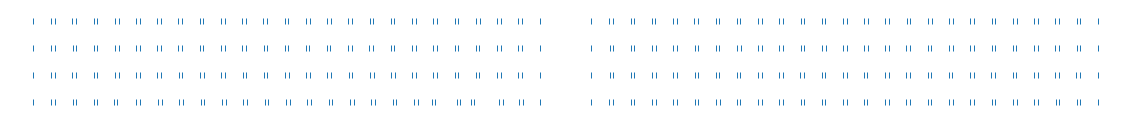

In [10]:
fig = plt.figure(figsize=(20, 2))
for i, crops in enumerate(crops_list):
    temp = pd.DataFrame(crops).to_numpy().flatten()
    sub = fig.add_subplot(4,2,i+1)
    sub.axis('off')
    sub.plot(temp,np.zeros_like(temp),'|')
plt.tight_layout
fig.subplots_adjust(wspace=.001, hspace=0)

##### Cropping Images and adding Individual Slices to new Array

In [11]:
multiview_strip_array = []

#For every View
for i, cropped_image in enumerate(cropped_img_list):
    min_width = float('inf')
    strip_array = []

    #First find the minimum width of all the crops
    for crop in crops_list[i]:
        front, back = crop
        min_width = min(min_width,back-front)

    #Get half of that min width
    min_width_half = int((min_width-2)/2)

    #For each of the crops, crop them from their own midpoint +- the mind_width_half value
    for crop in crops_list[i]:
        front, back = crop
        strip_mid = int(back/2 + front/2)
        min_front = strip_mid - min_width_half
        min_back = min_width_half + strip_mid
        strip_array.append(cropped_image[:,min_front:min_back])

    multiview_strip_array.append(strip_array)

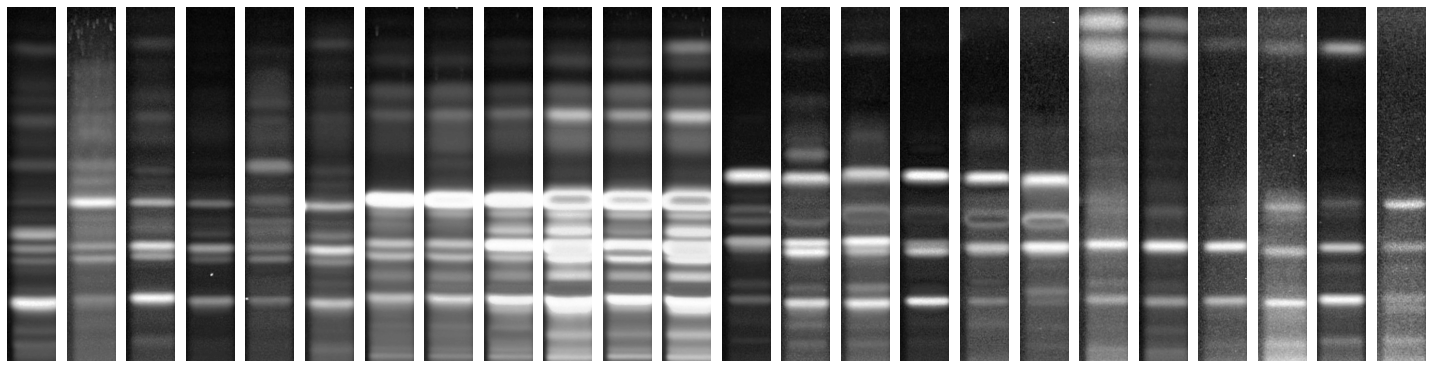

In [12]:
# Individual Print
# strip_array = strip_array_list[1]
strip_array = multiview_strip_array[1]
fig = plt.figure(figsize=(20, 10))
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray')
plt.tight_layout()

### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [13]:
multiview_strip_row_avg_list = []

for strip_array in multiview_strip_array:
    strip_row_avg = []

    for i, strip in enumerate(strip_array):
        strip_row_avg.append([])
        for row in strip:
            strip_row_avg[i].append(row.mean())

    multiview_strip_row_avg_list.append(strip_row_avg)

In [14]:
np.shape(multiview_strip_row_avg_list[0][0])

(1030,)

In [15]:
np.shape(np.transpose([multiview_strip_row_avg_list[0][i] for k in range(min_width)]))

(1030, 140)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

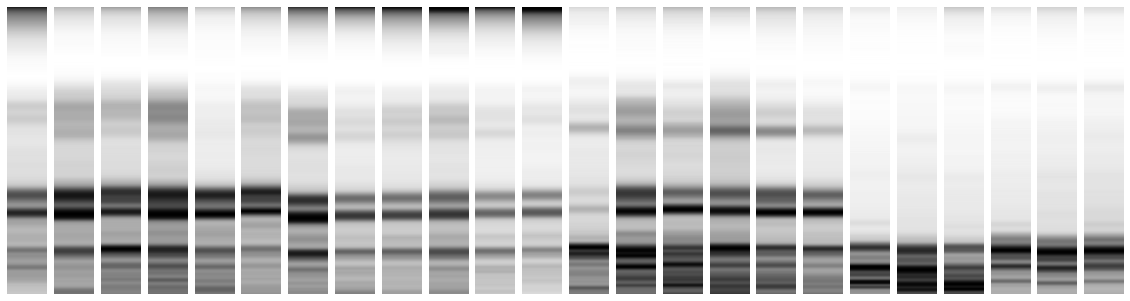

In [16]:
# Individual
fig = plt.figure(figsize=(20, 10)) 
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [multiview_strip_row_avg_list[-1][i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

### Setting up Target Values & Dictionary Mapping

In [17]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [18]:
np.shape(multiview_strip_row_avg_list)

(8, 24, 1030)

In [19]:
np.shape(multiview_strip_row_avg_list[0])

(24, 1030)

In [20]:
#Done for the purposes of appending all views into 1 long feature vector later
no_targets_multiview_strip_row_avg_list = np.array(multiview_strip_row_avg_list).copy()

##### Append Targets to feature array

In [21]:
for strip_row_avg in multiview_strip_row_avg_list:
    for i in range(6):
        # strip_row_avg[i].append(1)
        strip_row_avg[i] = np.append(strip_row_avg[i],1)
    for i in range(6,12):
        # strip_row_avg[i].append(2)
        strip_row_avg[i] = np.append(strip_row_avg[i],2)
    for i in range(12,18):
        # strip_row_avg[i].append(3)
        strip_row_avg[i] = np.append(strip_row_avg[i],3)
    for i in range(18,21):
        # strip_row_avg[i].append(4)
        strip_row_avg[i] = np.append(strip_row_avg[i],4)
    for i in range(21,24):
        # strip_row_avg[i].append(5)
        strip_row_avg[i] = np.append(strip_row_avg[i],5)

In [22]:
#Verifying Shape of Multiview Multi-Dimensional Array
print(np.shape(multiview_strip_row_avg_list))

(8, 24, 1031)


In [23]:
# Verifying values are w/n the 0 - 1 range
print(np.shape(multiview_strip_row_avg_list[0][0]))
print(max(multiview_strip_row_avg_list[0][0]))
print(min(multiview_strip_row_avg_list[0][0]))

(1031,)
1.0
0.046075564761115705


### RUN EVERYTHING ABOVE THIS
---

In [53]:
print('Run Above')

Run Above


### Developing Model on a Single View

In [25]:
single_view = multiview_strip_row_avg_list[0]

In [26]:
#Convert to Dataframe
strip_row_avg = pd.DataFrame(strip_row_avg)

#Get Features
df_feat = strip_row_avg.iloc[:,:-2]

#Get Targets & Format to 1D vector
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()

#Create Model
model = DecisionTreeClassifier()

#Set Model Parameters
model.set_params(max_depth=5)

#Train Model
model.fit(df_feat,df_target)

#Print Score
print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target)))


Strip 23: 1.0


### Applying Model to all Views

In [30]:
for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=100,
                    max_depth=2)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    print("View "+str(i+1)+": "+str(model.score(df_feat,df_target)))

View 1: 0.875
View 2: 0.875
View 3: 0.9583333333333334
View 4: 0.75
View 5: 0.9583333333333334
View 6: 1.0
View 7: 1.0
View 8: 1.0


## Exploring the Model

### Identifying Min & Max Depths of Trees in forest w/ 100 estimators to reach 100% Accuracy

In [33]:
results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=100,
                        random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    score = model.score(df_feat,df_target)
    # print("View "+str(i+1)+": "+str(score))

    #Get Depth of Every tree in forest
    depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

    #Get Max depth of a tree in the forest
    maxDepthOfTree = max(depthOfEveryTree)
    # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

    #Get Min depth of a tree in the forest
    minDepthOfTree = min(depthOfEveryTree)
    # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


    results.append([score,maxDepthOfTree,minDepthOfTree])

results = pd.DataFrame(results)
results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
display(results)


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               6               3
1       1.0               6               3
2       1.0               6               3
3       1.0               9               4
4       1.0               6               3
5       1.0               5               2
6       1.0               5               2
7       1.0               5               2

### Iterating through max_depths to determine min. depth necessary for 100% accuracy across all views 
    @ n_estimators = 100

In [32]:
max_depths = [2,3,4]

for md in max_depths:
    results = []

    for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

        #Convert to Dataframe
        strip_row_avg = pd.DataFrame(strip_row_avg)

        #Get Features
        df_feat = strip_row_avg.iloc[:,:-2]

        #Get Targets & Format to 1D vector
        df_target = strip_row_avg.iloc[:,-1:]
        df_target = df_target.values.ravel()

        #Create Model
        model = RandomForestClassifier()

        #Set Model Parameters
        model.set_params(n_estimators=100,
                        max_depth=md,
                        random_state=101)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        score = model.score(df_feat,df_target)
        # print("View "+str(i+1)+": "+str(score))

        #Get Depth of Every tree in forest
        depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

        #Get Max depth of a tree in the forest
        maxDepthOfTree = max(depthOfEveryTree)
        # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

        #Get Min depth of a tree in the forest
        minDepthOfTree = min(depthOfEveryTree)
        # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


        results.append([score,maxDepthOfTree,minDepthOfTree])

    results = pd.DataFrame(results)
    results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
    display(results)


Accuracy  MaxDepthOfTree  MinDepthOfTree
0  0.875000               2               2
1  0.916667               2               2
2  1.000000               2               2
3  0.708333               2               2
4  0.958333               2               2
5  1.000000               2               2
6  1.000000               2               2
7  1.000000               2               2

Accuracy  MaxDepthOfTree  MinDepthOfTree
0  1.000000               3               3
1  1.000000               3               3
2  1.000000               3               3
3  0.916667               3               3
4  1.000000               3               3
5  1.000000               3               2
6  1.000000               3               2
7  1.000000               3               2

Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               2
6       1.0               4               2
7       1.0               4               2

### Iterating through max_depths to determine min. depth necessary for 100% accuracy across all views 
    @ n_estimators = 1000

In [31]:
max_depths = [2,3,4]

for md in max_depths:
    results = []

    for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

        #Convert to Dataframe
        strip_row_avg = pd.DataFrame(strip_row_avg)

        #Get Features
        df_feat = strip_row_avg.iloc[:,:-2]

        #Get Targets & Format to 1D vector
        df_target = strip_row_avg.iloc[:,-1:]
        df_target = df_target.values.ravel()

        #Create Model
        model = RandomForestClassifier()

        #Set Model Parameters
        model.set_params(n_estimators=1000,
                        max_depth=md,
                        random_state=101)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        score = model.score(df_feat,df_target)
        # print("View "+str(i+1)+": "+str(score))

        #Get Depth of Every tree in forest
        depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

        #Get Max depth of a tree in the forest
        maxDepthOfTree = max(depthOfEveryTree)
        # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

        #Get Min depth of a tree in the forest
        minDepthOfTree = min(depthOfEveryTree)
        # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


        results.append([score,maxDepthOfTree,minDepthOfTree])

    results = pd.DataFrame(results)
    results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
    display(results)


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.875               2               2
1     0.875               2               2
2     1.000               2               2
3     0.750               2               2
4     1.000               2               2
5     1.000               2               2
6     1.000               2               2
7     1.000               2               2

Accuracy  MaxDepthOfTree  MinDepthOfTree
0  1.000000               3               2
1  1.000000               3               2
2  1.000000               3               3
3  0.916667               3               3
4  1.000000               3               2
5  1.000000               3               2
6  1.000000               3               2
7  1.000000               3               2

Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               2
1       1.0               4               2
2       1.0               4               3
3       1.0               4               3
4       1.0               4               2
5       1.0               4               2
6       1.0               4               2
7       1.0               4               2

### Conclusion: 

1) There is a very small benefit to increasing number of estimators from 100 to 1000 across these max_depth values.

2) Should we desire 100% Accuracy across each view, we need a max_depth of 4 at least. However, a max_depth of 3 is 'near perfect'

### Iterating through n_estimators to determine min. num necessary for 100% accuracy across all views @ depth 4

In [30]:
n_est = [10,20,30,40,50,60,70,80,90,100]

for ne in n_est:
    results = []

    for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

        #Convert to Dataframe
        strip_row_avg = pd.DataFrame(strip_row_avg)

        #Get Features
        df_feat = strip_row_avg.iloc[:,:-2]

        #Get Targets & Format to 1D vector
        df_target = strip_row_avg.iloc[:,-1:]
        df_target = df_target.values.ravel()

        #Create Model
        model = RandomForestClassifier()

        #Set Model Parameters
        model.set_params(n_estimators=ne,
                        max_depth=4,
                        random_state=101)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        score = round(model.score(df_feat,df_target),3)
        # print("View "+str(i+1)+": "+str(score))

        #Get Depth of Every tree in forest
        depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

        #Get Max depth of a tree in the forest
        maxDepthOfTree = max(depthOfEveryTree)
        # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

        #Get Min depth of a tree in the forest
        minDepthOfTree = min(depthOfEveryTree)
        # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


        results.append([score,maxDepthOfTree,minDepthOfTree])

    results = pd.DataFrame(results)
    results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
    print("Number of Estimators (trees): "+str(ne))
    display(results)


Number of Estimators (trees): 10


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.958               4               3
1     1.000               4               3
2     0.917               4               3
3     0.958               4               4
4     1.000               4               3
5     1.000               4               3
6     0.958               4               3
7     1.000               4               3

Number of Estimators (trees): 20


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               3
6       1.0               4               3
7       1.0               4               3

Number of Estimators (trees): 30


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               3
6       1.0               4               3
7       1.0               4               3

Number of Estimators (trees): 40


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               3
6       1.0               4               2
7       1.0               4               3

Number of Estimators (trees): 50


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               3
6       1.0               4               2
7       1.0               4               3

Number of Estimators (trees): 60


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               3
6       1.0               4               2
7       1.0               4               3

Number of Estimators (trees): 70


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               2
6       1.0               4               2
7       1.0               4               2

Number of Estimators (trees): 80


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               2
6       1.0               4               2
7       1.0               4               2

Number of Estimators (trees): 90


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               2
6       1.0               4               2
7       1.0               4               2

Number of Estimators (trees): 100


Accuracy  MaxDepthOfTree  MinDepthOfTree
0       1.0               4               3
1       1.0               4               3
2       1.0               4               3
3       1.0               4               4
4       1.0               4               3
5       1.0               4               2
6       1.0               4               2
7       1.0               4               2

#### Conclusion: For a depth of 4 and perfect 100% accuracy, we only need 20 trees

### Iterating through n_estimators @ a Max Depth of **1** to determine if we can get 100% accuracy

In [36]:
n_est = [100,250,500,750,1000]

for ne in n_est:
    results = []

    for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

        #Convert to Dataframe
        strip_row_avg = pd.DataFrame(strip_row_avg)

        #Get Features
        df_feat = strip_row_avg.iloc[:,:-2]

        #Get Targets & Format to 1D vector
        df_target = strip_row_avg.iloc[:,-1:]
        df_target = df_target.values.ravel()

        #Create Model
        model = RandomForestClassifier()

        #Set Model Parameters
        model.set_params(n_estimators=ne,
                        max_depth=1,
                        random_state=101)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        score = round(model.score(df_feat,df_target),3)
        # print("View "+str(i+1)+": "+str(score))

        #Get Depth of Every tree in forest
        depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

        #Get Max depth of a tree in the forest
        maxDepthOfTree = max(depthOfEveryTree)
        # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

        #Get Min depth of a tree in the forest
        minDepthOfTree = min(depthOfEveryTree)
        # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


        results.append([score,maxDepthOfTree,minDepthOfTree])

    results = pd.DataFrame(results)
    results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
    print("Number of Estimators (trees): "+str(ne))
    display(results)


Number of Estimators (trees): 100


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.750               1               1
1     0.750               1               1
2     0.833               1               1
3     0.583               1               1
4     0.917               1               1
5     0.750               1               1
6     0.875               1               1
7     0.708               1               1

Number of Estimators (trees): 250


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.750               1               1
1     0.750               1               1
2     0.792               1               1
3     0.583               1               1
4     0.875               1               1
5     0.750               1               1
6     0.750               1               1
7     0.708               1               1

Number of Estimators (trees): 500


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.750               1               1
1     0.750               1               1
2     0.708               1               1
3     0.583               1               1
4     0.875               1               1
5     0.750               1               1
6     0.750               1               1
7     0.750               1               1

Number of Estimators (trees): 750


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.750               1               1
1     0.750               1               1
2     0.708               1               1
3     0.583               1               1
4     0.917               1               1
5     0.750               1               1
6     0.750               1               1
7     0.750               1               1

Number of Estimators (trees): 1000


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.750               1               1
1     0.750               1               1
2     0.750               1               1
3     0.583               1               1
4     0.917               1               1
5     0.750               1               1
6     0.750               1               1
7     0.750               1               1

#### Conclusion: With a depth of 1, the accuracies are not high enough across the views to make the model useful even at a larger number of estimators

### Iterating through n_estimators @ a Max Depth of **2** to determine if we can get 100% accuracy

In [37]:
n_est = [100,250,500,750,1000]

for ne in n_est:
    results = []

    for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

        #Convert to Dataframe
        strip_row_avg = pd.DataFrame(strip_row_avg)

        #Get Features
        df_feat = strip_row_avg.iloc[:,:-2]

        #Get Targets & Format to 1D vector
        df_target = strip_row_avg.iloc[:,-1:]
        df_target = df_target.values.ravel()

        #Create Model
        model = RandomForestClassifier()

        #Set Model Parameters
        model.set_params(n_estimators=ne,
                        max_depth=2,
                        random_state=101)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        score = round(model.score(df_feat,df_target),3)
        # print("View "+str(i+1)+": "+str(score))

        #Get Depth of Every tree in forest
        depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

        #Get Max depth of a tree in the forest
        maxDepthOfTree = max(depthOfEveryTree)
        # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

        #Get Min depth of a tree in the forest
        minDepthOfTree = min(depthOfEveryTree)
        # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


        results.append([score,maxDepthOfTree,minDepthOfTree])

    results = pd.DataFrame(results)
    results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
    print("Number of Estimators (trees): "+str(ne))
    display(results)


Number of Estimators (trees): 100


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.875               2               2
1     0.917               2               2
2     1.000               2               2
3     0.708               2               2
4     0.958               2               2
5     1.000               2               2
6     1.000               2               2
7     1.000               2               2

Number of Estimators (trees): 250


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.875               2               2
1     0.875               2               2
2     0.958               2               2
3     0.750               2               2
4     1.000               2               2
5     1.000               2               2
6     1.000               2               2
7     1.000               2               2

Number of Estimators (trees): 500


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.875               2               2
1     0.875               2               2
2     0.958               2               2
3     0.750               2               2
4     0.958               2               2
5     1.000               2               2
6     1.000               2               2
7     1.000               2               2

Number of Estimators (trees): 750


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.875               2               2
1     0.875               2               2
2     1.000               2               2
3     0.750               2               2
4     0.958               2               2
5     1.000               2               2
6     1.000               2               2
7     1.000               2               2

Number of Estimators (trees): 1000


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.875               2               2
1     0.875               2               2
2     1.000               2               2
3     0.750               2               2
4     1.000               2               2
5     1.000               2               2
6     1.000               2               2
7     1.000               2               2

#### Conclusion: We can achieve reasonably high levels of accuracy with max depth = 2 using even a low number of estimators, but it is not 'near perfect'

### Iterating through n_estimators @ a Max Depth of **3** to determine if we can get 100% accuracy

In [38]:
n_est = [100,250,500,750,1000]

for ne in n_est:
    results = []

    for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

        #Convert to Dataframe
        strip_row_avg = pd.DataFrame(strip_row_avg)

        #Get Features
        df_feat = strip_row_avg.iloc[:,:-2]

        #Get Targets & Format to 1D vector
        df_target = strip_row_avg.iloc[:,-1:]
        df_target = df_target.values.ravel()

        #Create Model
        model = RandomForestClassifier()

        #Set Model Parameters
        model.set_params(n_estimators=ne,
                        max_depth=3,
                        random_state=101)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        score = round(model.score(df_feat,df_target),3)
        # print("View "+str(i+1)+": "+str(score))

        #Get Depth of Every tree in forest
        depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

        #Get Max depth of a tree in the forest
        maxDepthOfTree = max(depthOfEveryTree)
        # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

        #Get Min depth of a tree in the forest
        minDepthOfTree = min(depthOfEveryTree)
        # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


        results.append([score,maxDepthOfTree,minDepthOfTree])

    results = pd.DataFrame(results)
    results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
    print("Number of Estimators (trees): "+str(ne))
    display(results)


Number of Estimators (trees): 100


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.917               3               3
4     1.000               3               3
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

Number of Estimators (trees): 250


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               2
1     1.000               3               3
2     1.000               3               3
3     0.917               3               3
4     1.000               3               2
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

Number of Estimators (trees): 500


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               2
1     1.000               3               2
2     1.000               3               3
3     0.917               3               3
4     1.000               3               2
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

Number of Estimators (trees): 750


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               2
1     1.000               3               2
2     1.000               3               3
3     0.917               3               3
4     1.000               3               2
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

Number of Estimators (trees): 1000


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               2
1     1.000               3               2
2     1.000               3               3
3     0.917               3               3
4     1.000               3               2
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

#### Conclusion: We can achieve 'near perfect' accuracy across all views using a max depth of 3 and only 100 estimators

### Iterating through n_estimators < 100 to determine min num necessary for near perfect accuracy across all views @ depth 4

In [39]:
n_est = [10,20,30,40,50,60,70,80,90,100]

for ne in n_est:
    results = []

    for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

        #Convert to Dataframe
        strip_row_avg = pd.DataFrame(strip_row_avg)

        #Get Features
        df_feat = strip_row_avg.iloc[:,:-2]

        #Get Targets & Format to 1D vector
        df_target = strip_row_avg.iloc[:,-1:]
        df_target = df_target.values.ravel()

        #Create Model
        model = RandomForestClassifier()

        #Set Model Parameters
        model.set_params(n_estimators=ne,
                        max_depth=3,
                        random_state=101)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        score = round(model.score(df_feat,df_target),3)
        # print("View "+str(i+1)+": "+str(score))

        #Get Depth of Every tree in forest
        depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

        #Get Max depth of a tree in the forest
        maxDepthOfTree = max(depthOfEveryTree)
        # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

        #Get Min depth of a tree in the forest
        minDepthOfTree = min(depthOfEveryTree)
        # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


        results.append([score,maxDepthOfTree,minDepthOfTree])

    results = pd.DataFrame(results)
    results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree"})
    print("Number of Estimators (trees): "+str(ne))
    display(results)


Number of Estimators (trees): 10


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.917               3               3
1     0.917               3               3
2     0.958               3               3
3     0.875               3               3
4     0.958               3               3
5     1.000               3               3
6     0.958               3               3
7     1.000               3               3

Number of Estimators (trees): 20


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.958               3               3
1     0.958               3               3
2     1.000               3               3
3     0.917               3               3
4     0.958               3               3
5     1.000               3               3
6     1.000               3               3
7     1.000               3               3

Number of Estimators (trees): 30


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     0.958               3               3
1     1.000               3               3
2     1.000               3               3
3     0.875               3               3
4     0.958               3               3
5     1.000               3               3
6     1.000               3               3
7     1.000               3               3

Number of Estimators (trees): 40


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.958               3               3
4     1.000               3               3
5     1.000               3               3
6     1.000               3               2
7     1.000               3               3

Number of Estimators (trees): 50


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.917               3               3
4     1.000               3               3
5     1.000               3               3
6     1.000               3               2
7     1.000               3               3

Number of Estimators (trees): 60


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.917               3               3
4     1.000               3               3
5     1.000               3               3
6     1.000               3               2
7     1.000               3               3

Number of Estimators (trees): 70


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.958               3               3
4     1.000               3               3
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

Number of Estimators (trees): 80


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.958               3               3
4     1.000               3               3
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

Number of Estimators (trees): 90


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.917               3               3
4     1.000               3               3
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

Number of Estimators (trees): 100


Accuracy  MaxDepthOfTree  MinDepthOfTree
0     1.000               3               3
1     1.000               3               3
2     1.000               3               3
3     0.917               3               3
4     1.000               3               3
5     1.000               3               2
6     1.000               3               2
7     1.000               3               2

#### Conclusion: For a depth of 3 and near perfect 100% accuracy, we onlyy need 40 trees

---
### Takeaways from above:

For minimum number of leaves and high accuracy, use one of the following set of parameters

Option 1:
* Max Depth: 3
* Number of Estimators: 40
* Accuracy = 100 on all views but 1, which is at 95.8

Option 2:
* Max Depth: 4
* Number of Estimators: 20
* Accuracy: perfect 100% Accuracy on all views

### Counting the Number of Leaves in the above models

#### Number of leaves w/ - max_depth = 3, n_estimators = 40

In [55]:
results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=40,
                    max_depth=3,
                    random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    score = round(model.score(df_feat,df_target),3)
    # print("View "+str(i+1)+": "+str(score))

    #Get Every Tree in forest
    everyTree = [estimator for estimator in model.estimators_]

    #Get number of leaves in every tree
    numLeaves = 0
    for tree in everyTree:
        numLeaves += tree.tree_.n_leaves

    #Get Depth of Every tree in forest
    depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

    #Get Max depth of a tree in the forest
    maxDepthOfTree = max(depthOfEveryTree)
    # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

    #Get Min depth of a tree in the forest
    minDepthOfTree = min(depthOfEveryTree)
    # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


    results.append([score,maxDepthOfTree,minDepthOfTree,numLeaves])

results = pd.DataFrame(results)
results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree",3:"NumLeaves"})
# display(results)


In [56]:
resultsForMaxDepth3 = results.copy()
display(resultsForMaxDepth3)


Accuracy  MaxDepthOfTree  MinDepthOfTree  NumLeaves
0     1.000               3               3        191
1     1.000               3               3        175
2     1.000               3               3        188
3     0.958               3               3        191
4     1.000               3               3        202
5     1.000               3               3        177
6     1.000               3               2        172
7     1.000               3               3        180

#### Number of leaves w/ - max_depth = 4, n_estimators = 20

In [57]:
results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=20,
                    max_depth=4,
                    random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    score = model.score(df_feat,df_target)
    # print("View "+str(i+1)+": "+str(score))

    #Get Every Tree in forest
    everyTree = [estimator for estimator in model.estimators_]

    #Get number of leaves in every tree
    numLeaves = 0
    for tree in everyTree:
        numLeaves += tree.tree_.n_leaves

    #Get Depth of Every tree in forest
    depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

    #Get Max depth of a tree in the forest
    maxDepthOfTree = max(depthOfEveryTree)
    # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

    #Get Min depth of a tree in the forest
    minDepthOfTree = min(depthOfEveryTree)
    # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


    results.append([score,maxDepthOfTree,minDepthOfTree,numLeaves])

results = pd.DataFrame(results)
results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree",3:"NumLeaves"})
# display(results)


In [58]:
resultsForMaxDepth4 = results.copy()
display(resultsForMaxDepth4)

Accuracy  MaxDepthOfTree  MinDepthOfTree  NumLeaves
0       1.0               4               3        114
1       1.0               4               3        109
2       1.0               4               3        113
3       1.0               4               4        123
4       1.0               4               3        120
5       1.0               4               3        100
6       1.0               4               3         99
7       1.0               4               3        103

#### Comparing Max Depth 3 vs Max Depth 4 Results

In [67]:
resultsCompare = pd.concat([resultsForMaxDepth3["NumLeaves"],resultsForMaxDepth4["NumLeaves"]],axis=1)

In [68]:
display(resultsCompare)

NumLeaves  NumLeaves
0        191        114
1        175        109
2        188        113
3        191        123
4        202        120
5        177        100
6        172         99
7        180        103

---
#### Conclusion: Even though it has a greater depth, the model with Max Depth = 4 and N_estimators = 20 has fewer leaves.

## Exploring how Trees work in the Forest

##### Testing

In [70]:
results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=20,
                    max_depth=4,
                    random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    score = model.score(df_feat,df_target)
    # print("View "+str(i+1)+": "+str(score))

    #Get Every Tree in forest
    everyTree = [estimator for estimator in model.estimators_]

    #Get number of leaves in every tree
    numLeaves = 0
    for tree in everyTree:
        numLeaves += tree.tree_.n_leaves

    #Get Depth of Every tree in forest
    depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

    #Get Max depth of a tree in the forest
    maxDepthOfTree = max(depthOfEveryTree)
    # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

    #Get Min depth of a tree in the forest
    minDepthOfTree = min(depthOfEveryTree)
    # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


    results.append([score,maxDepthOfTree,minDepthOfTree,numLeaves])

results = pd.DataFrame(results)
results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree",3:"NumLeaves"})
display(results)


Accuracy  MaxDepthOfTree  MinDepthOfTree  NumLeaves
0       1.0               4               3        114
1       1.0               4               3        109
2       1.0               4               3        113
3       1.0               4               4        123
4       1.0               4               3        120
5       1.0               4               3        100
6       1.0               4               3         99
7       1.0               4               3        103

In [81]:
print(depthOfEveryTree)

[4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 4]


In [85]:
#get the top n features - UNSORTED
n = 20

topNFeatures = np.argpartition(model.feature_importances_,-n)[-n:]
print(topNFeatures)

[678 432 824 298  34 801  64 652   4 711   3   9  40 417 415  23 644 683
 690 657]


In [68]:
for tree in everyTree:
    # print(tree.classes_)
    # print(tree.tree_.n_leaves)
    print(tree.tree_.threshold)

    break

[ 0.58550164  0.2551593   0.1798669  -2.          0.1702454  -2.
 -2.          0.36016259 -2.         -2.         -2.        ]


In [72]:
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

##### Train the model on only the first view

In [90]:
results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=20,
                    max_depth=4,
                    random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    score = model.score(df_feat,df_target)
    # print("View "+str(i+1)+": "+str(score))

    #Get Every Tree in forest
    everyTree = [estimator for estimator in model.estimators_]

    #Get number of leaves in every tree
    numLeaves = 0
    for tree in everyTree:
        numLeaves += tree.tree_.n_leaves

    #Get Depth of Every tree in forest
    depthOfEveryTree = [estimator.tree_.max_depth for estimator in model.estimators_]

    #Get Max depth of a tree in the forest
    maxDepthOfTree = max(depthOfEveryTree)
    # print("Max Depth "+str(i+1)+": "+str(maxDepthOfTree))

    #Get Min depth of a tree in the forest
    minDepthOfTree = min(depthOfEveryTree)
    # print("Min Depth "+str(i+1)+": "+str(maxDepthOfTree))


    results.append([score,maxDepthOfTree,minDepthOfTree,numLeaves])

    break

results = pd.DataFrame(results)
results = results.rename(columns={0:"Accuracy",1:"MaxDepthOfTree",2:"MinDepthOfTree",3:"NumLeaves"})
display(results)


Accuracy  MaxDepthOfTree  MinDepthOfTree  NumLeaves
0       1.0               4               3        114

In [113]:
for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    # display(df_feat)

    #Get and Dislpay leaf indicies of sample applied to each tree in forest
    leafResultIndxs = model.apply(df_feat)
    display(pd.DataFrame(leafResultIndxs))

    break

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0    2   5   7   6   3   3   7   4   8   4   6   6   5   6   6   5   6   3   
1    2   6   4   6   7   3   7   4   3   6   4   6   6   3   7   5   4   3   
2    7   6   7   6   7   3   7   4   8   6  11   6   6   6   7   7  10  10   
3    4  11   7   6   7   3   7   4   9   6  11   9   6   6   7   7  11  10   
4    7  11   7   7   7   3   7   8   8   6  11   6   8   6   7   7  11  11   
5    2   6   7   6   7   3   7   4   5   6   6   6   6   6   7   6   6   3   
6    8  12   9   8   8   5  10   8  10   7  12  10   8  10   8   8  12   4   
7    8  12   7   8   8   5   9   8  10   7  12  10   8   8   8   8  12   4   
8    8  12  10   8   8   6  10   8  10   7  12  10   8  10   8   8  12   4   
9    8  12  10   8   8   6   4   8  10   7  12  10   8  10   8   8  12  12   
10   8  12  10   8   8   6  10   8  10   7  12  10   8  10   8   8  12  12   
11   8  12  10   8   8   6  10   8  10   7  12  10   8  10   8   8  12  12   
12   4  11   5   8   5   5  10   6   6   4  11   9   7   8   6   6  11  12   
13   4  11  10   8   6   5  10   6   6   8  11   9   7   9   7   7  11  12   
14   4   9   5   1   5   1   7   2   5   4   9   2   5   4   6   6   6   9   
15   4  11   7   7   5   5   9   6   9   8  11   9   7   8   6   6  11  12   
16   4  10   5   7   5   3   7   6   6   4  11   9   5   6   6   6  11  10   
17   7  11   5   7   6   5   7   7   6   8  11   9   7   8   8   6  11  12   
18   2   5   4   1   3   1   5   2   3   3   5   2   4   3   2   3   5   5   
19   2   5   4   1   3   1   5   2   3   3   5   2   5   4   2   3   6   5   
20   2   5   4   1   3   1   5   2   3   3   5   2   4   3   2   3   5   3   
21   2   3   3   5   3   1   3   2   3   4   4   5   5   4   4   5   6   9   
22   7  11   9   8   5   5   7   7   9   4  11   7   5   9   6   6   8  10   
23   6  10   5   7   5   5   7   7   5   4  10   7   5   4   6   6   6  10   

    18  19  
0    6   6  
1    4   2  
2    4   6  
3    6  11  
4    6   9  
5    4   6  
6    8  12  
7    8  12  
8    8  12  
9    8  12  
10   8  12  
11   8  12  
12   4   9  
13   7   9  
14   2   6  
15   6   9  
16   4   9  
17   4   9  
18   2   3  
19   2   3  
20   2   3  
21   2   2  
22   7  11  
23   6   7

In [119]:
#Gets the indexes of the leaves for every tree
indxOfLeavesEveryTree = []

for tree in everyTree:
    #Array where each node has the number of its left children BUT leaves have -1
    allChildren = tree.tree_.children_left
    #Get all leaves
    indxOfLeaves = np.where(allChildren == -1)[0]
    indxOfLeavesEveryTree.append(list(indxOfLeaves))
    
print(indxOfLeavesEveryTree)

[[2, 4, 6, 7, 8], [3, 5, 6, 9, 10, 11, 12], [3, 4, 5, 7, 9, 10], [1, 5, 6, 7, 8], [3, 5, 6, 7, 8], [1, 3, 5, 6], [3, 4, 5, 7, 9, 10], [2, 4, 6, 7, 8], [3, 5, 6, 8, 9, 10], [3, 4, 6, 7, 8], [4, 5, 6, 9, 10, 11, 12], [2, 5, 6, 7, 9, 10], [4, 5, 6, 7, 8], [3, 4, 6, 8, 9, 10], [2, 4, 6, 7, 8], [3, 5, 6, 7, 8], [4, 5, 6, 8, 10, 11, 12], [3, 4, 5, 9, 10, 11, 12], [2, 4, 6, 7, 8], [2, 3, 6, 7, 9, 11, 12]]


In [124]:
temp = np.concatenate(indxOfLeavesEveryTree)
print(len(temp))

114


In [144]:
#Get the encoding for each tree in a single view
singleViewInputLeafEncoding = []

#For every strip's row of resulting leaf indexes,
for stripLeafResultIndxs in leafResultIndxs:
    # print("stripLeafResultIndxs: "+str(stripLeafResultIndxs))

    #Create an array to save each tree's encoding to
    singleStripLeafEncoding = []

    #For every resulting leaf index in that row
    for treeNum, treeLeafResultIndex in enumerate(stripLeafResultIndxs):

        #Create the encoding for that tree
        treeLeafEncoding = [int(x == treeLeafResultIndex) for x in indxOfLeavesEveryTree[treeNum]]
        singleStripLeafEncoding.append(treeLeafEncoding.copy())

    #Append the encoding for that tree
    singleViewInputLeafEncoding.append(singleStripLeafEncoding.copy())
    
    # break
# print(singleViewInputLeafEncoding)
print(np.shape(singleViewInputLeafEncoding))
print(len(singleViewInputLeafEncoding[0]))
print(len(np.concatenate(np.squeeze(singleViewInputLeafEncoding))))

(24, 20)
20
480


In [134]:
#Testing Array Index Splicing
a = [1,2,3,4,5]
c = [int(x == 3) for x in a]
print(c)

[0, 0, 1, 0, 0]


In [145]:
display(pd.DataFrame(singleViewInputLeafEncoding))

0                      1                   2   \
0   [1, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]  [0, 0, 0, 1, 0, 0]   
1   [1, 0, 0, 0, 0]  [0, 0, 1, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0]   
2   [0, 0, 0, 1, 0]  [0, 0, 1, 0, 0, 0, 0]  [0, 0, 0, 1, 0, 0]   
3   [0, 1, 0, 0, 0]  [0, 0, 0, 0, 0, 1, 0]  [0, 0, 0, 1, 0, 0]   
4   [0, 0, 0, 1, 0]  [0, 0, 0, 0, 0, 1, 0]  [0, 0, 0, 1, 0, 0]   
5   [1, 0, 0, 0, 0]  [0, 0, 1, 0, 0, 0, 0]  [0, 0, 0, 1, 0, 0]   
6   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 0, 1]  [0, 0, 0, 0, 1, 0]   
7   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 0, 1]  [0, 0, 0, 1, 0, 0]   
8   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]   
9   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]   
10  [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]   
11  [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]   
12  [0, 1, 0, 0, 0]  [0, 0, 0, 0, 0, 1, 0]  [0, 0, 1, 0, 0, 0]   
13  [0, 1, 0, 0, 0]  [0, 0, 0, 0, 0, 1, 0]  [0, 0, 0, 0, 0, 1]   
14  [0, 1, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0]  [0, 0, 1, 0, 0, 0]   
15  [0, 1, 0, 0, 0]  [0, 0, 0, 0, 0, 1, 0]  [0, 0, 0, 1, 0, 0]   
16  [0, 1, 0, 0, 0]  [0, 0, 0, 0, 1, 0, 0]  [0, 0, 1, 0, 0, 0]   
17  [0, 0, 0, 1, 0]  [0, 0, 0, 0, 0, 1, 0]  [0, 0, 1, 0, 0, 0]   
18  [1, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0]   
19  [1, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0]   
20  [1, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0]   
21  [1, 0, 0, 0, 0]  [1, 0, 0, 0, 0, 0, 0]  [1, 0, 0, 0, 0, 0]   
22  [0, 0, 0, 1, 0]  [0, 0, 0, 0, 0, 1, 0]  [0, 0, 0, 0, 1, 0]   
23  [0, 0, 1, 0, 0]  [0, 0, 0, 0, 1, 0, 0]  [0, 0, 1, 0, 0, 0]   

                 3                4             5                   6   \
0   [0, 0, 1, 0, 0]  [1, 0, 0, 0, 0]  [0, 1, 0, 0]  [0, 0, 0, 1, 0, 0]   
1   [0, 0, 1, 0, 0]  [0, 0, 0, 1, 0]  [0, 1, 0, 0]  [0, 0, 0, 1, 0, 0]   
2   [0, 0, 1, 0, 0]  [0, 0, 0, 1, 0]  [0, 1, 0, 0]  [0, 0, 0, 1, 0, 0]   
3   [0, 0, 1, 0, 0]  [0, 0, 0, 1, 0]  [0, 1, 0, 0]  [0, 0, 0, 1, 0, 0]   
4   [0, 0, 0, 1, 0]  [0, 0, 0, 1, 0]  [0, 1, 0, 0]  [0, 0, 0, 1, 0, 0]   
5   [0, 0, 1, 0, 0]  [0, 0, 0, 1, 0]  [0, 1, 0, 0]  [0, 0, 0, 1, 0, 0]   
6   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 1]  [0, 0, 1, 0]  [0, 0, 0, 0, 0, 1]   
7   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 1]  [0, 0, 1, 0]  [0, 0, 0, 0, 1, 0]   
8   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 1]  [0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]   
9   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 1]  [0, 0, 0, 1]  [0, 1, 0, 0, 0, 0]   
10  [0, 0, 0, 0, 1]  [0, 0, 0, 0, 1]  [0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]   
11  [0, 0, 0, 0, 1]  [0, 0, 0, 0, 1]  [0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]   
12  [0, 0, 0, 0, 1]  [0, 1, 0, 0, 0]  [0, 0, 1, 0]  [0, 0, 0, 0, 0, 1]   
13  [0, 0, 0, 0, 1]  [0, 0, 1, 0, 0]  [0, 0, 1, 0]  [0, 0, 0, 0, 0, 1]   
14  [1, 0, 0, 0, 0]  [0, 1, 0, 0, 0]  [1, 0, 0, 0]  [0, 0, 0, 1, 0, 0]   
15  [0, 0, 0, 1, 0]  [0, 1, 0, 0, 0]  [0, 0, 1, 0]  [0, 0, 0, 0, 1, 0]   
16  [0, 0, 0, 1, 0]  [0, 1, 0, 0, 0]  [0, 1, 0, 0]  [0, 0, 0, 1, 0, 0]   
17  [0, 0, 0, 1, 0]  [0, 0, 1, 0, 0]  [0, 0, 1, 0]  [0, 0, 0, 1, 0, 0]   
18  [1, 0, 0, 0, 0]  [1, 0, 0, 0, 0]  [1, 0, 0, 0]  [0, 0, 1, 0, 0, 0]   
19  [1, 0, 0, 0, 0]  [1, 0, 0, 0, 0]  [1, 0, 0, 0]  [0, 0, 1, 0, 0, 0]   
20  [1, 0, 0, 0, 0]  [1, 0, 0, 0, 0]  [1, 0, 0, 0]  [0, 0, 1, 0, 0, 0]   
21  [0, 1, 0, 0, 0]  [1, 0, 0, 0, 0]  [1, 0, 0, 0]  [1, 0, 0, 0, 0, 0]   
22  [0, 0, 0, 0, 1]  [0, 1, 0, 0, 0]  [0, 0, 1, 0]  [0, 0, 0, 1, 0, 0]   
23  [0, 0, 0, 1, 0]  [0, 1, 0, 0, 0]  [0, 0, 1, 0]  [0, 0, 0, 1, 0, 0]   

                 7                   8                9   \
0   [0, 1, 0, 0, 0]  [0, 0, 0, 1, 0, 0]  [0, 1, 0, 0, 0]   
1   [0, 1, 0, 0, 0]  [1, 0, 0, 0, 0, 0]  [0, 0, 1, 0, 0]   
2   [0, 1, 0, 0, 0]  [0, 0, 0, 1, 0, 0]  [0, 0, 1, 0, 0]   
3   [0, 1, 0, 0, 0]  [0, 0, 0, 0, 1, 0]  [0, 0, 1, 0, 0]   
4   [0, 0, 0, 0, 1]  [0, 0, 0, 1, 0, 0]  [0, 0, 1, 0, 0]   
5   [0, 1, 0, 0, 0]  [0, 1, 0, 0, 0, 0]  [0, 0, 1, 0, 0]   
6   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 1]  [0, 0, 0, 1, 0]   
7   [0, 0, 0, 0, 1]  [0, 0, 0, 0, 0

## Get the Encoding for every Sample on every Tree in every View

In [146]:
multiViewInputLeafEncoding = []
#Train the model per view
for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=20,
                    max_depth=4,
                    random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Get Every Tree in forest
    everyTree = [estimator for estimator in model.estimators_]

    #Get leaf indicies of sample applied to each tree in forest
    leafResultIndxs = model.apply(df_feat)

    #Gets the indexes of the leaves for every tree
    indxOfLeavesEveryTree = []
    for tree in everyTree:
        #Array where each node has the number of its left children BUT leaves have -1
        allChildren = tree.tree_.children_left
        #Get all leaves
        indxOfLeaves = np.where(allChildren == -1)[0]
        indxOfLeavesEveryTree.append(list(indxOfLeaves))
        
    #Get the encoding for each tree in a single view
    singleViewInputLeafEncoding = []

    #For every strip's row of resulting leaf indexes,
    for stripLeafResultIndxs in leafResultIndxs:

        #Create an array to save each tree's encoding to
        singleStripLeafEncoding = []

        #For every resulting leaf index in that row
        for treeNum, treeLeafResultIndex in enumerate(stripLeafResultIndxs):

            #Create the encoding for that tree
            treeLeafEncoding = [int(x == treeLeafResultIndex) for x in indxOfLeavesEveryTree[treeNum]]
            singleStripLeafEncoding.append(treeLeafEncoding.copy())

        #Append the encoding for that tree
        singleViewInputLeafEncoding.append(singleStripLeafEncoding.copy())

    #Append the encoding created for a view to a list of all the views
    multiViewInputLeafEncoding.append(singleViewInputLeafEncoding)

In [147]:
print(np.shape(multiViewInputLeafEncoding))

(8, 24, 20)


c:\Python39\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
